_This notebook is part of the material for the [Tutorials for ML4HEP](https://gitlab.com/hepcedar/mcnet-schools/zakopane-2022) session._

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramonpeter/ML4HEP-Tutorial/blob/main/solution/top_tagging_sol.ipynb)

# Top-Tagging with Neural Networks

### Importing the libraries

In [5]:
# NN and data structures
import tensorflow as tf
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Part 1 - Data Preprocessing (don't change)

### Download the datasets
We load datasets for training (100k), validation (30k) and testing (30k).

In [ ]:
!curl https://www.dropbox.com/s/abd8xntlaorzzvy/train_img.h5?dl=1 -L -o train_img.h5
!curl https://www.dropbox.com/s/cmxe03vjfzhm70i/val_img.h5?dl=1 -L -o val_img.h5
!curl https://www.dropbox.com/s/csxe65ykvmomxcs/test_img.h5?dl=1 -L -o test_img.h5

### Load the data and reshape


In [6]:
def get_dataset(name):
    raw_data = pd.read_hdf(name, "table").iloc[:, :].values
    images, labels = raw_data[:,:-2].reshape((-1,40,40,1)), raw_data[:,-2]
    return images, labels

In [7]:
# Load the training set and check shape
train_images, train_labels = get_dataset("train_img.h5")
print(train_images.shape)

(100000, 40, 40, 1)


In [8]:
# Load validation set and check shape
val_images,val_labels = get_dataset("val_img.h5")
print(val_images.shape)

# Load test set and check shape
test_images, test_labels = get_dataset("test_img.h5")
print(test_images.shape)

(30000, 40, 40, 1)
(30000, 40, 40, 1)


### Visualize the Jet images

We first have a look into some random single Jet images from the validation set.

In [ ]:
# Plot
classes = ["Top jet", "QCD jet"]
plt.figure(figsize=(11,11))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.yticks([0, 10, 20, 30, 40])
    plt.xticks([0, 10, 20, 30, 40])
    plt.grid(False)
    plt.imshow(val_images[i].squeeze(), cmap=cm.jet)
    plt.xlabel(classes[int(val_labels[i])], fontsize = 12)
plt.show()

We can also have a look into an average Top and QCD jet (10k average):

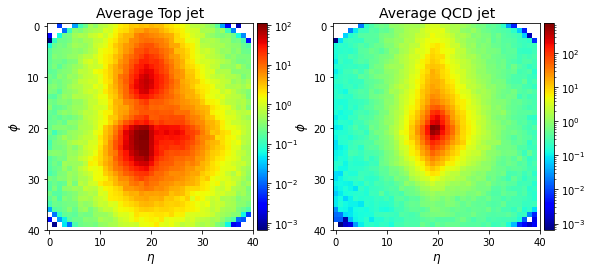

In [9]:
# Get signal and background images
sig = val_labels > 0
sig_images = val_images[sig]
bg_images = val_images[~sig]
k = 10000 # number of jet images averaged over

# calculate average jet image
average_sig = np.sum(sig_images[:k],axis=0)
average_bg = np.sum(bg_images[:k],axis=0)
average = [average_sig, average_bg]
label = ["Average Top jet", "Average QCD jet"]

# Plotting
fig, axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'wspace' : 0.3})
plt.subplots_adjust(left=0.07, right=0.95, top=0.96, bottom=0.05)
for i in range(2):
    axs[i].grid(False)
    im = axs[i].imshow(average[i].squeeze(), cmap=cm.jet, norm=colors.LogNorm())
    axs[i].set_title(label[i], fontsize = 14)
    axs[i].set_xlabel(r'$\eta$', fontsize = 12)
    axs[i].set_ylabel(r'$\phi$', fontsize = 12)
    axs[i].set_yticks([0, 10, 20, 30, 40])
    axs[i].set_xticks([0, 10, 20, 30, 40])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_aspect('equal', adjustable='box')
plt.show()

## Part 2 - Building the Model

Needed parts:
- Input layer (if [Functional API](https://keras.io/guides/functional_api/)) or initilize [sequential model](https://keras.io/guides/sequential_model/)
- Add combination of [convolutions](https://keras.io/api/layers/convolution_layers/) and [pooling](https://keras.io/api/layers/pooling_layers/) layers (for `CNN` only)
- [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) + [Fully Connected](https://keras.io/api/layers/core_layers/dense/) layers
- Output layer with apropriate activation function



### MLP Model

In [13]:
mlp = tf.keras.models.Sequential(name="MLP_Tagger")

# Flatten
mlp.add(tf.keras.layers.Flatten(input_shape=(40, 40, 1)))

# Fully connected
mlp.add(tf.keras.layers.Dense(units=128, activation='relu'))
mlp.add(tf.keras.layers.Dense(units=64, activation='relu'))
mlp.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer, units = 2 and "softmax" would also work!
mlp.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# print the summary
print(mlp.summary())

Model: "MLP_Tagger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               204928    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 215,297
Trainable params: 215,297
Non-trainable params: 0
_________________________________________________________________
None


### CNN Model

In [14]:
cnn = tf.keras.models.Sequential(name="CNN_Tagger")

# Convolution and Max-Pooling
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, padding='same', activation='relu', input_shape=[40, 40, 1]))
cnn.add(tf.keras.layers.MaxPool2D())
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D())

# Flatten and fully connected
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer, units = 2 and "softmax" would also work!
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# print the summary
print(cnn.summary())

Model: "CNN_Tagger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        32800     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3200)              0

## Part 3 - Training the model

### Compiling the Model

Check the [model.compile](https://keras.io/api/models/model_training_apis/#compile-method) function.  
- Use Adam optimizer and Binary-Crossentropy Loss (or CategoricalCrossentropy, depends on the Model!!)
- Use accuracy as metric

In [15]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
mlp.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Train on the training set and evaluate on the validation set

- Use the Keras built-in [model.fit](https://keras.io/api/models/model_training_apis/#fit-method) function.
- Define the number of `epochs`
- Choose an appropriate `batch_size`

### Train MLP

In [16]:
mlp.fit(x = train_images, y = train_labels, validation_data=(test_images, test_labels), epochs = 4, batch_size=128)

2022-06-15 15:35:22.133595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3235 - accuracy: 0.8658 - val_loss: 0.2829 - val_accuracy: 0.8781
Epoch 2/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2676 - accuracy: 0.8871 - val_loss: 0.2700 - val_accuracy: 0.8875
Epoch 3/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2479 - accuracy: 0.8968 - val_loss: 0.2621 - val_accuracy: 0.8905
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2316 - accuracy: 0.9041 - val_loss: 0.2614 - val_accuracy: 0.8908


### Train CNN

In [17]:
cnn.fit(x = train_images, y = train_labels, validation_data=(test_images, test_labels), epochs = 4, batch_size=128)

Epoch 1/4
782/782 [==============================] - 104s 133ms/step - loss: 0.2831 - accuracy: 0.8799 - val_loss: 0.2469 - val_accuracy: 0.8972
Epoch 2/4
782/782 [==============================] - 99s 127ms/step - loss: 0.2407 - accuracy: 0.9009 - val_loss: 0.2362 - val_accuracy: 0.9016
Epoch 3/4
782/782 [==============================] - 108s 139ms/step - loss: 0.2319 - accuracy: 0.9047 - val_loss: 0.2372 - val_accuracy: 0.9004
Epoch 4/4
782/782 [==============================] - 103s 132ms/step - loss: 0.2243 - accuracy: 0.9083 - val_loss: 0.2273 - val_accuracy: 0.9068


Possibly detect overfitting (val acc << train acc) and adjust training: -> ASK ME

## Part 4 - Plotting the results

Check your model on the test set and do:

- Evaluate and plot the [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) curve, 
but use the more common LHC standard (x-axis: Signal efficiency = true positive rate, y-axis: Background rejection = 1/(false positive rate))
- Calculate the Area Under the Curve ([AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc))
- Compare with random classifier

### Import necessary libraries and test images

In [18]:
from sklearn.metrics import roc_curve, auc

### Determine and plot ROC curve with AUC

In [20]:
# MLP
predictions_mlp = mlp.predict(test_images)
fpr_mlp, tpr_mlp, thresholds = roc_curve(test_labels.ravel(), predictions_mlp.ravel())
auc_mlp = auc(fpr_mlp, tpr_mlp)

# CNN
predictions_cnn = cnn.predict(test_images)
fpr_cnn, tpr_cnn, thresholds = roc_curve(test_labels.ravel(), predictions_cnn.ravel())
auc_cnn = auc(fpr_cnn, tpr_cnn)

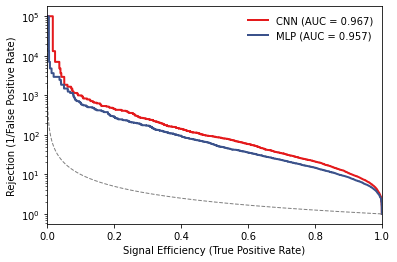

In [23]:
# Colors
dcolor = '#3b528b'
gcolor = '#e41a1c'

# reference line
tpr_ref = np.linspace(0,1,1000)
fpr_ref = np.linspace(0,1,1000)

lw = 2
epsilon = 1e-5

plt.figure()
plt.plot(
    tpr_cnn,
    1/(fpr_cnn+epsilon),
    color=gcolor,
    lw=lw,
    label="CNN (AUC = %0.3f)" % auc_cnn,
)
plt.plot(
    tpr_mlp,
    1/(fpr_mlp+epsilon),
    color=dcolor,
    lw=lw,
    label="MLP (AUC = %0.3f)" % auc_mlp,
)
plt.plot(tpr_ref, 1/(fpr_ref+epsilon), color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.yscale('log')
plt.xlabel("Signal Efficiency (True Positive Rate)")
plt.ylabel("Rejection (1/False Positive Rate)")
plt.legend(loc="upper right", frameon=False)
plt.savefig('ROC.pdf', format='pdf')
plt.show()